In [471]:
import networkx as nx
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib notebook
%matplotlib
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

Using matplotlib backend: nbAgg


In [472]:
# read network and dynamics
def readnet_dynamic(net_name, N):   
    G0 = nx.Graph()
    G0.add_nodes_from(range(0,N))
    
    name_path = r'data\\'+net_name+'\\'+net_name
    f = open(name_path+'.txt')               
    lines = f.readlines()          
    for line in lines:             
        listline1 = line.strip('\n').split(' ')[0] 
        listline2 = line.strip('\n').split(' ')[1]
        G0.add_edges_from([(int(listline1), int(listline2))])
    f.close()
    
    # read dynamics  
    x1 = np.loadtxt(name_path+'_threshold_x.txt', dtype=np.float32, delimiter=' ')  # T*N
    y1 = np.loadtxt(name_path+'_threshold_y.txt', dtype=np.float32, delimiter=' ')  
    x2 = np.loadtxt(name_path+'_voter_x.txt', dtype=np.float32, delimiter=' ')  # T*N
    y2 = np.loadtxt(name_path+'_voter_y.txt', dtype=np.float32, delimiter=' ') 
    x3 = np.loadtxt(name_path+'_ising_x.txt', dtype=np.float32, delimiter=' ')  # T*N
    y3 = np.loadtxt(name_path+'_ising_y.txt', dtype=np.float32, delimiter=' ') 
    x4 = np.loadtxt(name_path+'_SIS_x.txt', dtype=np.float32, delimiter=' ')  # T*N
    y4 = np.loadtxt(name_path+'_SIS_y.txt', dtype=np.float32, delimiter=' ') 
    x5 = np.loadtxt(name_path+'_SIR_x.txt', dtype=np.float32, delimiter=' ')  # T*N
    y5 = np.loadtxt(name_path+'_SIR_y.txt', dtype=np.float32, delimiter=' ') 
    
    x1 = x1+np.ones(N)  
    y1 = y1+np.ones(N)
    x2 = x2+np.ones(N)  
    y2 = y2+np.ones(N)
    x3 = x3+np.ones(N)  
    y3 = y3+np.ones(N)
    x4 = x4+np.ones(N)  
    y4 = y4+np.ones(N)
    x5 = x5+np.ones(N)  
    y5 = y5+np.ones(N)
    
    return G0, x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, name_path


In [473]:
#read data
#net_name='BA_N200_m2' N=200
#net_name='ER_N200_p002' N=200
#net_name='WS_N200_k4_p05' N=200
#net_name='dolphins' N=62
#net_name='parsed_word' N=112
#net_name='ca-netscience' N=379
#net_name='email' N=1133

net_name='ER_N200_p002'
N=200
G0, X_th, Y_th, X_voter, Y_voter, X_ising, Y_ising, X_sis, Y_sis, X_sir, Y_sir, net_path = readnet_dynamic(net_name, N)

In [474]:
G0.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199))

In [475]:
X=X_voter
Y=Y_voter

In [476]:
#random remove edges
def RemoveRandomEdges(G,n_edges):
    edge_id=[]
    for i in range(n_edges):
        rdm_edges_id = np.random.choice(range(G.number_of_edges()))
        edge_id.append(rdm_edges_id)
        edges = list(G.edges())
        e = edges[rdm_edges_id]
        G.remove_edge(*e)
    return G,edge_id

In [477]:
#random remove edges
n=len(np.array(G0.edges))
s=n*0.1   # 0.1 is Proportion
G1,edge_id=RemoveRandomEdges(G0.copy(),int(s))#partial network
print(len(G0.edges),len(G1.edges))

522 470


In [478]:
W0 = nx.to_numpy_array(G0)
W1 = nx.to_numpy_array(G1)

In [479]:
import torch
from torch_geometric.nn import DenseGINConv,DenseGCNConv
from torch.nn import Sequential, Linear, ReLU, LSTM, BatchNorm1d
device = torch.device("cpu")        
    
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.fc1 = nn.Sequential(
            torch.nn.Linear(in_channels, 32),
            torch.nn.ReLU())
        self.conv = DenseGCNConv(32, 32)
        self.relu = torch.nn.ReLU()
        self.fc2 = nn.Linear(32, out_channels)
    def forward(self, x, adj):
        x = self.fc1(x)
        x = self.relu(self.conv(x, adj))
        x = self.fc2(x)
        return x

In [480]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.nn.parameter import Parameter

def gumbel_sample(shape, eps=1e-20):
    u = torch.rand(shape)
    gumbel = - np.log(- np.log(u + eps) + eps)
    gumbel = gumbel.to(device)
    return gumbel
def gumbel_softmax_sample(logits, temperature): 
    y = logits + gumbel_sample(logits.size())
    return torch.nn.functional.softmax( y / temperature, dim = 1)

def gumbel_softmax(logits, temperature, hard=False):
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        y_hard = torch.max(y.data, 1)[1]
        y = y_hard
    return y

In [481]:
class Gumbel_Generator(nn.Module):
    def __init__(self, sz = 10, temp = 10, temp_drop_frac = 0.9999):
        super(Gumbel_Generator, self).__init__()
        self.gen_matrix = Parameter(torch.rand(sz, sz, 2))
        self.temperature = temp
        self.temp_drop_frac = temp_drop_frac
    def drop_temperature(self):
        self.temperature = self.temperature * self.temp_drop_frac
    def sample(self, hard=False):
        self.logp = self.gen_matrix.view(-1, 2)
        out = gumbel_softmax(self.logp, self.temperature, hard)
        if hard:
            hh = torch.zeros(self.gen_matrix.size()[0] ** 2, 2)
            for i in range(out.size()[0]):
                hh[i, out[i]] = 1
            out = hh
            out = out.to(device)
        out_matrix = out[:,0].view(self.gen_matrix.size()[0], self.gen_matrix.size()[0])
        return out_matrix
    def get_temperature(self):
        return self.temperature

In [482]:
import numpy as np
import torch.optim as optim
from torch.autograd import Variable
import argparse
import time
import copy
import pickle
import os
import datetime

def train_batch_dyn(w1,optimizer_dyn,dyn_learner,adj,data_train,data_target,loss_fn,r2):
    loss = 0
    optimizer_dyn.zero_grad()
    adj=adj+w1
    adj = adj.unsqueeze(0)
    adj = adj.repeat(data_train.size()[0],1,1)
    output = dyn_learner(data_train,adj)
    output = output.permute(0,2,1)
    data_target = data_target.long()
    loss = loss_fn (output[:,:,r2],data_target[:,r2])
    loss.backward() 
    optimizer_dyn.step()
    return loss

def train_batch_net(w1,optimizer_network,gumbel_generator,dyn_learner,data_train,data_target,loss_fn,r2):
    loss=0
    optimizer_network.zero_grad()    
    p = gumbel_generator.sample()
    out_matrix=p+w1
    out_matrix = out_matrix.unsqueeze(0)
    out_matrix = out_matrix.repeat(data_train.size()[0], 1, 1)
    gumbel_generator.drop_temperature()
    output = dyn_learner(data_train,out_matrix)
    output = output.permute(0,2,1)
    data_target = data_target.long()
    loss = loss_fn(output[:,:,r2],data_target[:,r2])
    loss=loss+(1/(len(w1)*len(w1)))*torch.norm(p,p=1)
    loss.backward()
    optimizer_network.step()
    return loss

In [483]:
#batch
batch_num=9
n=0.1*len(G0.nodes) # 0.1 is Proportion
s1=[]
s2=[]
#remove node dynamics
for i in range(batch_num):
    r1=random.sample(range(G1.number_of_nodes()),int(n))
    r2=[i for i in range(G1.number_of_nodes())]
    for i in r1:
        r2.remove(i)
    s1.append(r1)
    s2.append(r2)
#batch size
batch=100
s1

[[89,
  90,
  104,
  122,
  163,
  169,
  85,
  23,
  129,
  0,
  98,
  84,
  138,
  168,
  8,
  35,
  158,
  113,
  116,
  29],
 [169,
  163,
  168,
  105,
  26,
  99,
  92,
  149,
  68,
  19,
  150,
  85,
  74,
  111,
  53,
  183,
  167,
  43,
  136,
  2],
 [185,
  51,
  28,
  92,
  116,
  59,
  83,
  88,
  10,
  163,
  66,
  143,
  65,
  55,
  196,
  134,
  95,
  125,
  41,
  85],
 [186,
  167,
  25,
  70,
  36,
  31,
  32,
  105,
  12,
  48,
  3,
  195,
  152,
  131,
  91,
  145,
  51,
  58,
  94,
  129],
 [191,
  11,
  35,
  189,
  136,
  61,
  77,
  4,
  118,
  164,
  46,
  142,
  160,
  139,
  96,
  162,
  182,
  91,
  188,
  140],
 [152,
  189,
  160,
  76,
  119,
  143,
  172,
  106,
  57,
  15,
  136,
  77,
  38,
  46,
  183,
  146,
  89,
  22,
  138,
  24],
 [129,
  142,
  175,
  125,
  149,
  169,
  84,
  40,
  26,
  151,
  89,
  42,
  31,
  9,
  72,
  7,
  92,
  184,
  164,
  137],
 [48,
  24,
  42,
  7,
  113,
  162,
  199,
  97,
  85,
  73,
  8,
  13,
  66,
  41,
  63,
 

In [484]:
use_cuda=True
device = torch.device("cuda" if use_cuda else "cpu")

num_nodes = len(W1)
in_channels = 1
out_channels = 2   #if SIR  ,out_channels=3
#dynamics leraner
dyn_learner = GCNNet(in_channels, out_channels).to(device)
print(dyn_learner)

optimizer_dyn = optim.Adam(dyn_learner.parameters(),lr = 0.001)

#network inference
gumbel_generator = Gumbel_Generator(sz = num_nodes,temp = 10,temp_drop_frac = 0.9999).to(device)
#gumbel_generator = gumbel_generator.double()
optimizer_network = optim.Adam(gumbel_generator.parameters(),lr = 0.1)

    
#pratial network
w1=torch.tensor(W1)
w1=w1.float()
w1=w1.to(device)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()
#epochs
Epoch_Num=10
#rounds of dynamics leraner 
Dyn_Steps=20
#rounds of network inference 
Net_Steps=10

#data transpose
X1=X.T
X2=X1.copy()
Y1=Y.T
Y2=Y1.copy()


loss = 0
# start training
losses = []
accuracies = []
losses_in_gumbel = []
for epoch in range(Epoch_Num):
    print('epoch running:'+str(epoch)+' / '+str(Epoch_Num))
    adj = gumbel_generator.sample(hard=True)
    print("\n***************Dyn Training******************")
    # dynamics.train()
    for i in range(Dyn_Steps):
        for j in range(batch_num):
            X3=X2.copy()
            Y3=Y2.copy()-1
            X3[s1[j],:]=0
            Y3[s1[j],:]=0
            data_train=torch.Tensor(X3[:,batch*j:batch*(j+1)].T)[:,:,None]
            data_target=torch.Tensor(Y3[:,batch*j:batch*(j+1)].T)
            data_train=data_train.to(device)
            data_target=data_target.to(device)
            loss = train_batch_dyn(w1,optimizer_dyn,dyn_learner,adj,data_train,data_target,loss_fn,s2[j])
            record_loss = loss.data.tolist()
        losses.append(record_loss)
        print("\n")
        print('epoch: '+str(epoch)+' dyn training '+str(i))
        print('loss: '+str(record_loss))
    print("\n***************Net Training******************")
    # network.train()
    for i in range(Net_Steps):
        for j in range(batch_num):
            X3=X2.copy()
            Y3=Y2.copy()-1
            X3[s1[j],:]=0
            Y3[s1[j],:]=0
            data_train=torch.Tensor(X3[:,batch*j:batch*(j+1)].T)[:,:,None]
            data_target=torch.Tensor(Y3[:,batch*j:batch*(j+1)].T)
            data_train=data_train.to(device)
            data_target=data_target.to(device)
            loss= train_batch_net(w1,optimizer_network,gumbel_generator,dyn_learner,data_train,data_target,loss_fn,s2[j])
            record_loss = loss.data.tolist()
        losses_in_gumbel.append(record_loss)
        print("\n")
        print('epoch: '+str(epoch)+' net training '+str(i))
        print('loss: '+str(record_loss))

GCNNet(
  (fc1): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
  )
  (conv): DenseGCNConv(32, 32)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)
epoch running:0 / 10

***************Dyn Training******************


epoch: 0 dyn training 0
loss: 0.6912701725959778


epoch: 0 dyn training 1
loss: 0.692541778087616


epoch: 0 dyn training 2
loss: 0.6915085911750793


epoch: 0 dyn training 3
loss: 0.6910826563835144


epoch: 0 dyn training 4
loss: 0.6911219954490662


epoch: 0 dyn training 5
loss: 0.6905103921890259


epoch: 0 dyn training 6
loss: 0.6902145147323608


epoch: 0 dyn training 7
loss: 0.6897237300872803


epoch: 0 dyn training 8
loss: 0.6892504692077637


epoch: 0 dyn training 9
loss: 0.6887107491493225


epoch: 0 dyn training 10
loss: 0.6881124377250671


epoch: 0 dyn training 11
loss: 0.6875422596931458


epoch: 0 dyn training 12
loss: 0.6869920492172241


epoch: 0 dyn training 13
loss: 0.686371564865112



epoch: 4 net training 5
loss: 0.5944021940231323


epoch: 4 net training 6
loss: 0.5935037732124329


epoch: 4 net training 7
loss: 0.5925239324569702


epoch: 4 net training 8
loss: 0.5917832255363464


epoch: 4 net training 9
loss: 0.5908830761909485
epoch running:5 / 10

***************Dyn Training******************


epoch: 5 dyn training 0
loss: 0.5718343257904053


epoch: 5 dyn training 1
loss: 0.5718337893486023


epoch: 5 dyn training 2
loss: 0.5718334317207336


epoch: 5 dyn training 3
loss: 0.5718328356742859


epoch: 5 dyn training 4
loss: 0.5718309283256531


epoch: 5 dyn training 5
loss: 0.5718286633491516


epoch: 5 dyn training 6
loss: 0.5718260407447815


epoch: 5 dyn training 7
loss: 0.5718241333961487


epoch: 5 dyn training 8
loss: 0.5718217492103577


epoch: 5 dyn training 9
loss: 0.571820080280304


epoch: 5 dyn training 10
loss: 0.5718180537223816


epoch: 5 dyn training 11
loss: 0.5718154311180115


epoch: 5 dyn training 12
loss: 0.5718133449554443


epoch: 5 d



epoch: 9 net training 4
loss: 0.5766147971153259


epoch: 9 net training 5
loss: 0.5765010118484497


epoch: 9 net training 6
loss: 0.5762404203414917


epoch: 9 net training 7
loss: 0.5761818885803223


epoch: 9 net training 8
loss: 0.5760297775268555


epoch: 9 net training 9
loss: 0.5759326815605164


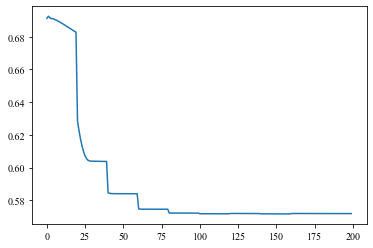

In [485]:
plt.plot(losses)

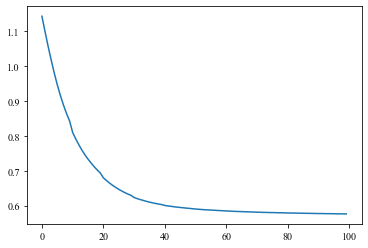

In [486]:
plt.plot(losses_in_gumbel)

In [487]:
#dyn_acc
pp=gumbel_generator.sample()
acc=0
z=0
x1=torch.tensor(X2)
x1=x1.float()
y1=torch.tensor(Y2)
y1=y1.float()
for t in range(900,1000):
    z=z+1
    x=x1[...,t:t+1].to(device)
    y=y1[...,t:t+1].to(device)-1
    y=y.view(1, -1)[0].long()
    adj=pp+w1
    y_pred = dyn_learner(x, adj)
    y_pred1=F.softmax(y_pred,2)
    p=torch.argmax(y_pred1, axis=2)
    for i in range(len(adj)):
        if p[0][i]==y[i]:
            acc=acc+1            
print("\n***************Dynamics prediction accuracy******************")
print(acc/(len(adj)*z))


***************Dynamics prediction accuracy******************
0.70145


0.9998116

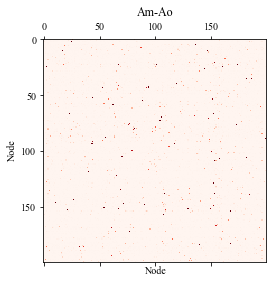

In [488]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
pp = gumbel_generator.sample()
pp=pp.cpu()
a=pp.detach().numpy()
a[W1>0]=0
plt.matshow(a, cmap="Reds")
plt.xlabel("Node")
plt.ylabel("Node")
plt.title('Am-Ao')
#np.savetxt("Am-Ao(0.1).txt",a,fmt="%.4f")
np.max(a)

Text(0.5, 1.0, 'A-Ao')

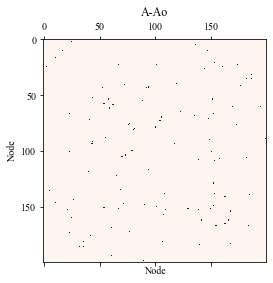

In [489]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
#pp = gumbel_generator.sample()
#pp=pp.cpu()
plt.matshow(W0-W1, cmap="Reds")
plt.xlabel("Node")
plt.ylabel("Node")
plt.title('A-Ao')
#np.savetxt("A-Ao(0.1).txt",W0-W1,fmt="%.4f")

In [490]:
#network inference
from scipy import sparse
pp = gumbel_generator.sample()
pp=pp.cpu()
p=W1+pp.detach().numpy()

perturbation=p
perturbation = (perturbation+perturbation.T)/2    
for i in range(0,perturbation.shape[0]):
    perturbation[i][i]=0

perturbation[W1>0] = 0 #remove Ao
perturbation=perturbation/(np.max(perturbation))
#sort predicted edges
a=sparse.dok_matrix(perturbation)
b = sorted(a.items(), key=lambda x: x[1], reverse=True)

#sort real edges
c=sparse.dok_matrix(W0-W1)
d = sorted(c.items(), key=lambda x: x[1], reverse=True)

In [491]:
A=[]
B=[]
#s：remove the number of edges
for i in range(int(s)*2):
    A.append(b[i][0])
for i in range(int(s)*2):
    B.append(d[i][0])
print("\n***************Network inference accuracy******************")
print('acc:',len(set(A)&set(B))/(int(s)*2))


***************Network inference accuracy******************
acc: 0.9230769230769231


In [492]:
#True rank of removed edges
d1=[]
for i in range(len(d)):
    if d[i][0][0]<d[i][0][1]:
        d1.append(d[i])
d2=d1[:]
   
b1=[]
for i in range(len(b)):
    if b[i][0][0]<b[i][0][1]:
        b1.append(b[i])
b2=b1[:]
        
for i in range(len(b1)):
    for j in range(len(d1)):
        if b1[i][0]==d1[j][0]:
            print(b1[i])
            print('The rank of prediction')
            print(i)

((107, 157), 1.0)
The rank of prediction
0
((40, 119), 0.995000114351426)
The rank of prediction
1
((44, 94), 0.9909599755994631)
The rank of prediction
2
((27, 144), 0.9907107580718316)
The rank of prediction
3
((3, 25), 0.9903493061850226)
The rank of prediction
4
((77, 172), 0.9902950675295116)
The rank of prediction
5
((44, 53), 0.9887508909198617)
The rank of prediction
6
((11, 146), 0.9882406181811253)
The rank of prediction
7
((55, 88), 0.987240885557719)
The rank of prediction
8
((43, 94), 0.9836379061946776)
The rank of prediction
9
((129, 152), 0.9827833566464135)
The rank of prediction
10
((67, 152), 0.9813862714538258)
The rank of prediction
11
((23, 67), 0.9728198140279054)
The rank of prediction
12
((70, 105), 0.9692936752449915)
The rank of prediction
13
((139, 184), 0.9439489862037912)
The rank of prediction
14
((54, 151), 0.9429113849204074)
The rank of prediction
15
((21, 153), 0.9294790432301168)
The rank of prediction
16
((71, 147), 0.9153870414101549)
The rank of p

<function matplotlib.pyplot.show(close=None, block=None)>

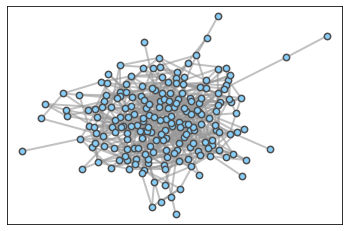

In [493]:
pos1 = nx.spring_layout(G0)
nx.draw_networkx_nodes(G0, pos1, node_size=40, linewidths=1.5, edgecolors='.3',
                       node_color='lightskyblue')
nx.draw_networkx_edges(G0, pos1, width=2, alpha=0.6, edge_color='.6')
plt.show

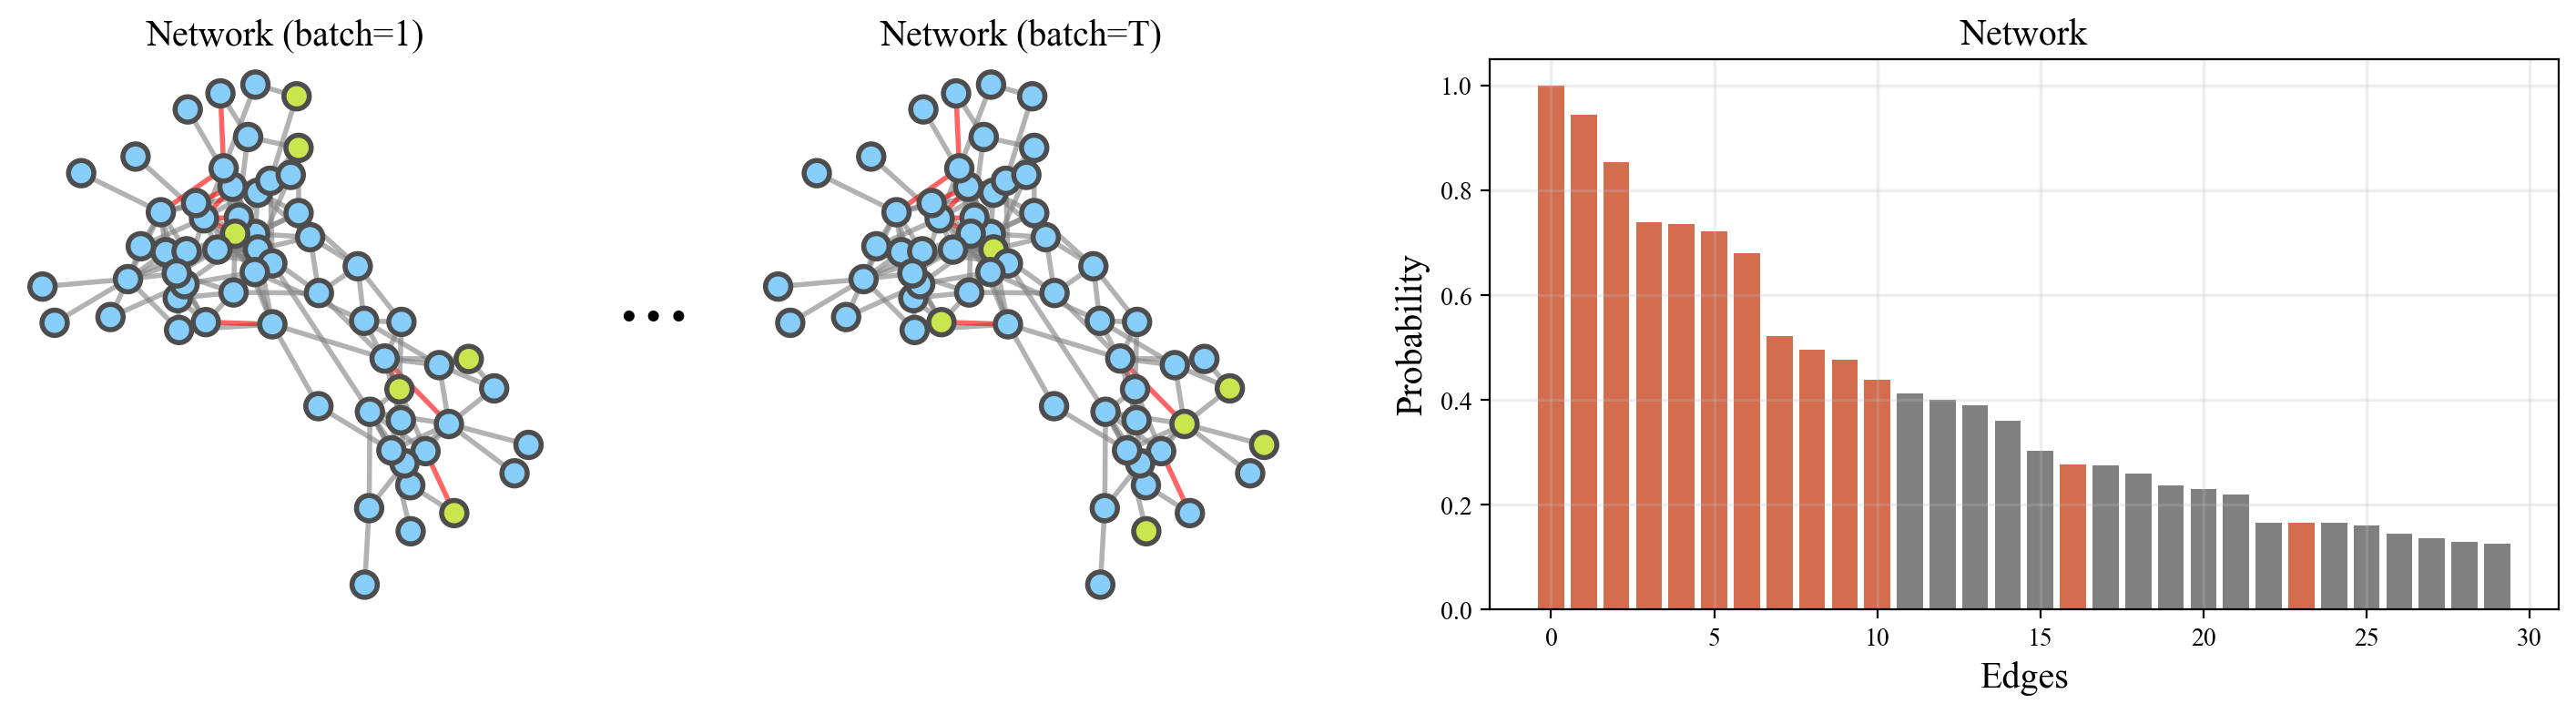

In [248]:

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',  
    "font.size": 10,
}
rcParams.update(config)


fig, ax = plt.subplots(1,5,figsize=(18,4),dpi=200,gridspec_kw={'width_ratios':[0.5,0.1,0.5,0.1,1]})
plt.subplots_adjust(wspace=0.1)

t0=['lightskyblue' for i in range(len(w1))]
for i in s1[0]:
    t0[i]='#CBE54E'

t9=['lightskyblue' for i in range(len(w1))]
for i in s1[8]:
    t9[i]='#CBE54E'


fff=['grey' for i in range(len(G0.edges))]
for i in edge_id:
    fff[i]='r'

nx.draw_networkx_nodes(G0, pos1, node_size=100, linewidths=2, edgecolors='.3',
                       node_color=t0, ax=ax[0])
nx.draw_networkx_edges(G0, pos1, width=2, alpha=0.6, edge_color=fff,ax=ax[0])
ax[0].set_title('Network (batch=1)',fontsize='x-large',color='k')
ax[0].set_axis_off()

ax[1].set_title('...',fontsize=40,color='k',y=0.5)
ax[1].set_axis_off()
nx.draw_networkx_nodes(G0, pos1, node_size=100, linewidths=2, edgecolors='.3',
                       node_color=t9, ax=ax[2])
nx.draw_networkx_edges(G0, pos1, width=2, alpha=0.6, edge_color=fff,ax=ax[2])
ax[2].set_title('Network (batch=T)',fontsize='x-large',color='k')
ax[2].set_axis_off()

ax[3].set_axis_off()
value=[]
color_value=['grey' for i in range(int(s)*2)]
for i in range(int(s)*4):
    if i%2==0:
        value.append(b[i][1])
        sb = set([])
        sb.add(b[i][0])
        if len(sb&set(B))==1:
            color_value[int(i/2)]='#D46C4E'
ax[4].bar(x=list(range(int(s)*2)), height=value[:int(s)*2],color=color_value)
ax[4].grid(linewidth=1.25,color='.75',alpha=0.25)
ax[4].set_ylabel('Probability', fontsize='x-large', color='k')
ax[4].set_xlabel('Edges', fontsize='x-large', color='k')
ax[4].set_title('Network',fontsize='x-large',color='k')
#plt.savefig("PSPD_word_0.2.eps",dpi=100,format='eps')
plt.show()

